In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
import torch.nn.init as init
import tqdm
import sys
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

REAL = 1.
FAKE = 0.

class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=110, out_features=384*4*4),
            nn.ReLU(inplace=True),

            Reshape((-1, 384, 4, 4)),

            nn.ConvTranspose2d(in_channels=384, out_channels=192, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=192, out_channels=96, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=96, out_channels=3, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )
        self.apply(self.init_weights)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        return self.model(x)

    def init_weights(self, m):
      if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.normal_(m.weight, mean=0, std=0.02)
        if m.bias is not None:
            init.zeros_(m.bias)

In [76]:
G = Generator()
G.load_state_dict(torch.load("G_100ac.pth")['state_dict'])
G.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=110, out_features=6144, bias=True)
    (1): ReLU(inplace=True)
    (2): Reshape()
    (3): ConvTranspose2d(384, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(192, 96, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (7): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(96, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (10): Tanh()
  )
)

In [99]:
def create_sample_seeding() -> torch.Tensor:
  batch_tensors = []
  for i in range(2):
      random_part = torch.normal(mean=0, std = 1, size = (100, 1, 1)) # better to use uniform random or normal random?
      one_hot_vector = torch.zeros(10, 1, 1)
      label = 0
      one_hot_vector[label] = 1
      complete_tensor = torch.cat((random_part, one_hot_vector), dim=0)
      batch_tensors.append(complete_tensor)

  final_tensor = torch.stack(batch_tensors)
  return final_tensor

def display_image(image):
    image = image / 2 + .5
    image = image.detach().cpu().numpy()
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()

def display_lsi(images):
  fig, axs = plt.subplots(1, 10)
  for i in range(10):
    image = images[i]
    image = image / 2 + .5
    image = image.detach().cpu().numpy()
    axs[i].imshow(np.transpose(image, (1, 2, 0)))
    axs[i].axis('off')
  fig.subplots_adjust(wspace=0.05)
  plt.show()

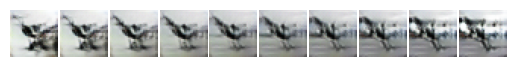

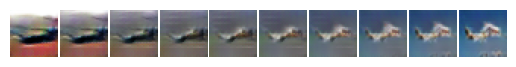

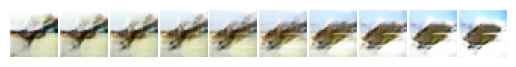

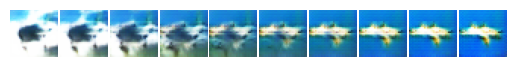

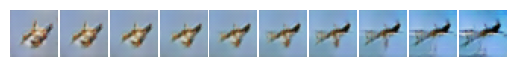

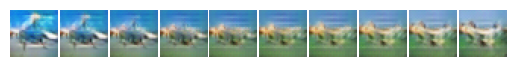

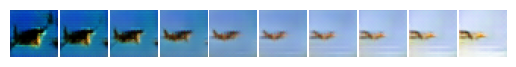

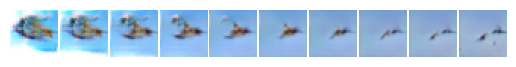

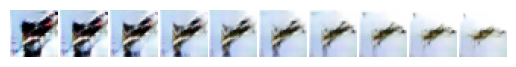

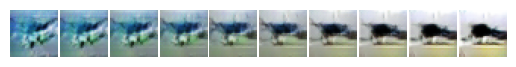

In [100]:
# torch.manual_seed(42)
for i in range(10):
  seedings = create_sample_seeding()

  va = seedings.detach().cpu().numpy()[0]
  vb = seedings.detach().cpu().numpy()[1]

  vs = np.linspace(va, vb, 10)

  vst = torch.tensor(vs)
  # seedings = torch.from_numpy(vs).float().to(device
  out = G(vst)

  display_lsi(out)